

# **Origen de los datos**

Los datos obtenidos para este proyecto corresponden a un conjunto de 500 imágenes de documentos de identidad. De estas, 250 imágenes representan documentos reales y las otras 250 son imágenes generadas artificialmente, donde se superponen datos falsos sobre documentos auténticos. Estos datos fueron recopilados de un servicio de almacenamiento en la nube llamado AWS.

A continuación, se presenta un ejemplo de cómo se descargaron los datos desde Amazon S3 hacia un entorno local (por sencibilidad de datos y credenciales no se adjuntan solo se mencionan):


```
import boto3

# Establecer las credenciales de AWS
access_key = 'TU_ACCESS_KEY'
secret_key = 'TU_SECRET_KEY'
region_name = 'TU_REGION_NAME'

# Crear una instancia del cliente de AWS S3
s3_client = boto3.client('s3', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=region_name)

# Nombre del bucket de S3 donde están almacenados los datos
bucket_name = 'NOMBRE_DEL_BUCKET'

# Directorio local donde se guardarán los datos descargados
local_directory = 'DIRECTORIO_LOCAL'

# Descargar los archivos desde S3 al directorio local
response = s3_client.download_file(bucket_name, 'CARPETA_EN_S3/nombre_del_archivo.jpg', f'{local_directory}/nombre_del_archivo.jpg')


```



Una vez que los datos se descargaron al entorno local, se organizaron en una carpeta compartida en Google Drive para facilitar el acceso y la colaboración entre los miembros del proyecto. Esto se hizo para que todos los involucrados pudieran acceder fácilmente a los datos y trabajar en conjunto en el desarrollo del proyecto.

En resumen, se recopilaron 500 imágenes de documentos de identidad, de las cuales 250 son documentos reales y 250 son imágenes generadas artificialmente. Estos datos fueron obtenidos de AWS mediante una descarga desde Amazon S3 hacia un entorno local. Posteriormente, se organizaron en una carpeta compartida en Google Drive para facilitar el acceso y la colaboración en el proyecto.

# Conexion a google drive

In [2]:
!apt install tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [3]:
#descarga del corpus
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
path_data  = '/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG'

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG
!tree -L 1

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG
.
├── FALSE
└── TRUE

2 directories, 0 files


In [5]:
import os
import random
from PIL import Image, ImageDraw, ImageFilter
import xml.etree.ElementTree as ET
import os
import cv2

def get_region_coordinates(xml_path):
    """
    Función que lee un archivo XML y devuelve las coordenadas de la región de interés.
    """
    # with open(xml_path) as f:
    #     xml = f.read()
    # root = etree.fromstring(xml)
    # xmin = int(root.xpath("//xmin/text()")[0])
    # ymin = int(root.xpath("//ymin/text()")[0])
    # xmax = int(root.xpath("//xmax/text()")[0])
    # ymax = int(root.xpath("//ymax/text()")[0])
    # return xmin, ymin, xmax, ymax


    # Parseamos el archivo xml para obtener las coordenadas de recorte
    print('ingresa',xml_path)
    tree = ET.parse(xml_path)
    print("tree")
    root = tree.getroot()
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    print(xmin, ymin, xmax, ymax)
    return xmin, ymin, xmax, ymax

def convinate_images(img_in, img_out):
  # Leer las imágenes
  # foreground_image = cv2.imread(img_out)
  # background_image = cv2.imread(img_in)
  foreground_image = (img_out)
  background_image = (img_in)

  # Redimensionar las imágenes si es necesario (asegúrate de que ambas tengan el mismo tamaño)
  # foreground_image = cv2.resize(foreground_image, (background_image.shape[1], background_image.shape[0]))

  # Crear una máscara binaria de la imagen en primer plano
  foreground_mask = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2GRAY)
  _, foreground_mask = cv2.threshold(foreground_mask, 1, 255, cv2.THRESH_BINARY)

  # Invertir la máscara para obtener la máscara del fondo
  background_mask = cv2.bitwise_not(foreground_mask)

  # Aplicar las máscaras a las imágenes
  foreground = cv2.bitwise_and(foreground_image, foreground_image, mask=foreground_mask)
  background = cv2.bitwise_and(background_image, background_image, mask=background_mask)

  # Combinar las imágenes superponiendo la imagen en primer plano sobre la imagen de fondo
  combined_image = cv2.add(foreground, background)

  # Guardar la imagen combinada
  # cv2.imwrite(img_convinate, combined_image)
  return combined_image
from PIL import Image, ImageDraw, ImageFilter, ImageChops

def procesar_imagenes(ruta):
    # Obtener la lista de archivos en la ruta
    archivos = os.listdir(ruta)

    # Filtrar solo los archivos de imagen (por extensión)
    archivos_imagen = [archivo for archivo in archivos if archivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Seleccionar aleatoriamente 5 imágenes
    imagenes_seleccionadas = random.sample(archivos_imagen, 5)

    for imagen in imagenes_seleccionadas:
        # Leer la imagen
        ruta_imagen = os.path.join(ruta, imagen)
        img = Image.open(ruta_imagen)

        # Leer el archivo XML asociado
        ruta_xml = os.path.splitext(ruta_imagen)[0] + '.xml'
        if os.path.isfile(ruta_xml):
            # Parsear el archivo XML
            tree = ET.parse(ruta_xml)
            root = tree.getroot()

            # Obtener las coordenadas del recuadro
            coordenadas = []
            xmin, ymin, xmax, ymax = get_region_coordinates(ruta_xml)
            coordenadas.append((xmin, ymin, xmax, ymax))
            print(xmin, ymin, xmax, ymax)

            # Dibujar los recuadros en la imagen
            draw = ImageDraw.Draw(img)
            for coord in coordenadas:
                draw.rectangle(coord, outline='red')

            # Crear una máscara con el rectángulo
            mask = Image.new('L', img.size, 0)
            mask_draw = ImageDraw.Draw(mask)
            mask_draw.rectangle((xmin, ymin, xmax, ymax), fill=255)

            # Aplicar el filtro de difuminado a las áreas fuera del rectángulo
            blurred_img = ImageChops.composite(img, Image.new('RGB', img.size), mask)
            filter_img = img.filter(ImageFilter.BoxBlur(15))
            print(type(blurred_img))

            # Crear una nueva imagen del tamaño de la imagen de fondo (img1)
            combined_img = Image.new('RGB', img.size)

            # Pega la primera imagen (img1) en la imagen combinada
            combined_img.paste(blurred_img, (0, 0))

            # Crear una máscara en blanco del tamaño de la imagen combinada
            mask = Image.new('L', combined_img.size, 0)

            # Pega la imagen borrada (blurred_img) en la máscara
            mask.paste(filter_img, (0, 0))

            # Pega la segunda imagen (img2) en la imagen combinada utilizando la máscara
            combined_img.paste(filter_img, (0, 0), mask=mask)
            # combined_img.show()
            # Especifica el tamaño deseado para la visualización
            tamaño_visualización = (800, 600)

            # Redimensiona la imagen combinada al tamaño de visualización
            combined_img_resized = combined_img.resize(tamaño_visualización)

            # Mostrar la imagen combinada redimensionada
            combined_img_resized.show()


        else:
            print(f"No se encontró el archivo XML asociado a la imagen: {imagen}")


/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE
ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42746891.xml
tree
22 96 317 469
22 96 317 469
<class 'PIL.Image.Image'>


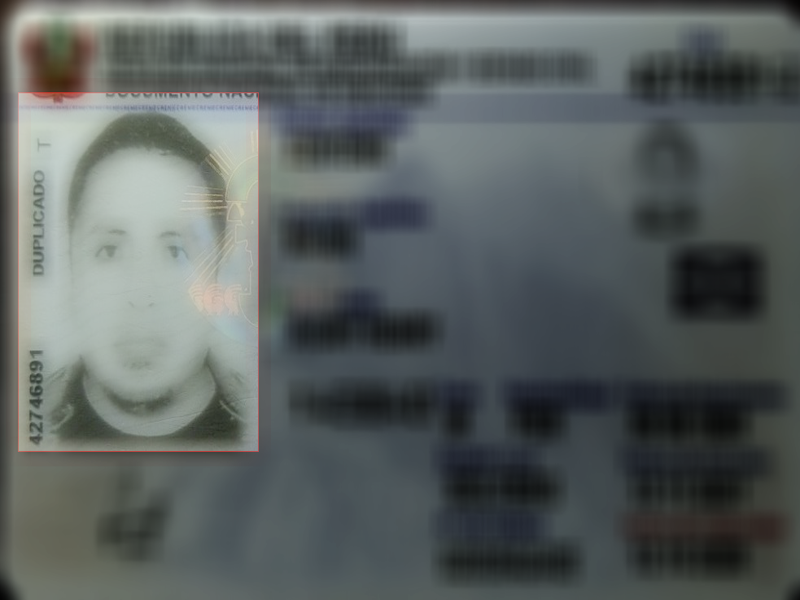

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41983973.xml
tree
116 699 530 1193
116 699 530 1193
<class 'PIL.Image.Image'>


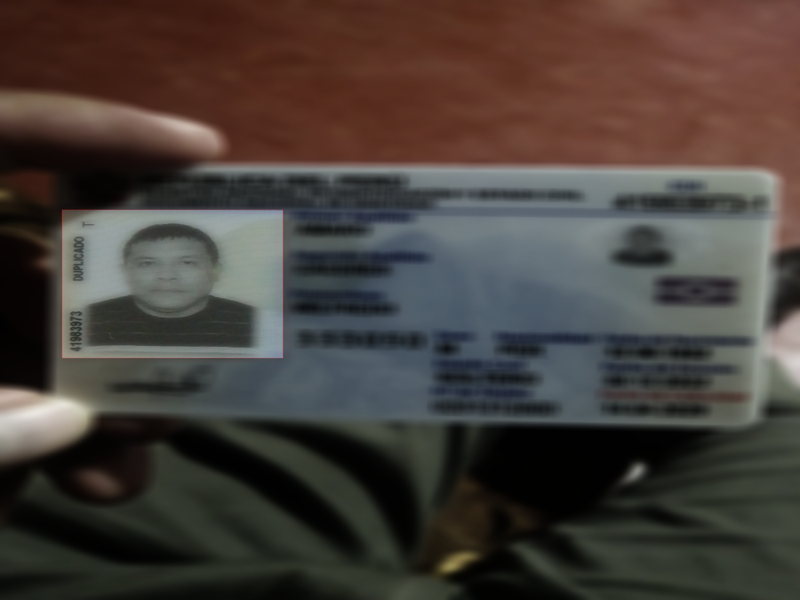

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10684520.xml
tree
29 168 501 746
29 168 501 746
<class 'PIL.Image.Image'>


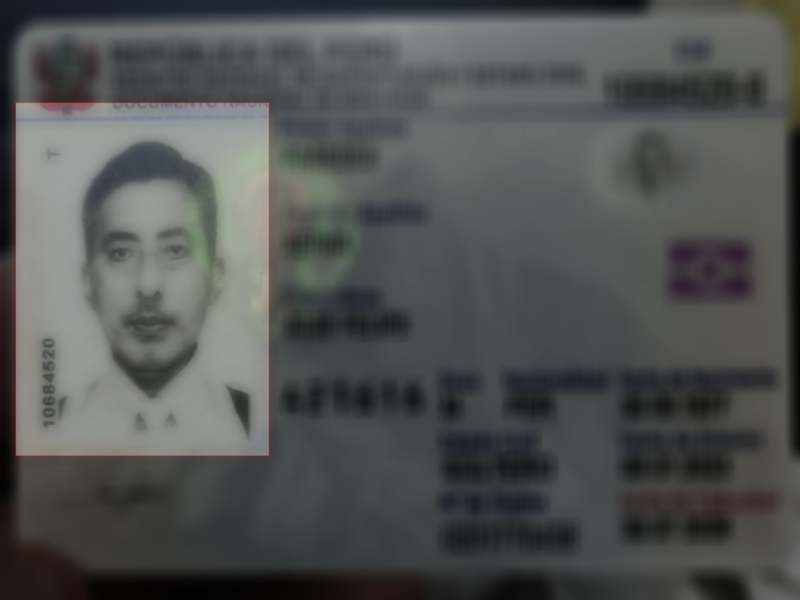

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18133932.xml
tree
20 112 308 459
20 112 308 459
<class 'PIL.Image.Image'>


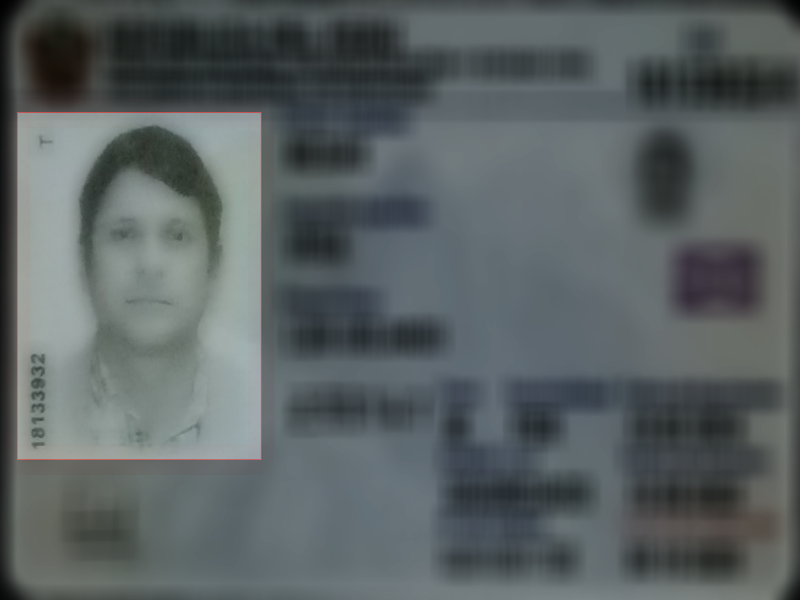

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06622315.xml
tree
574 83 847 444
574 83 847 444
<class 'PIL.Image.Image'>


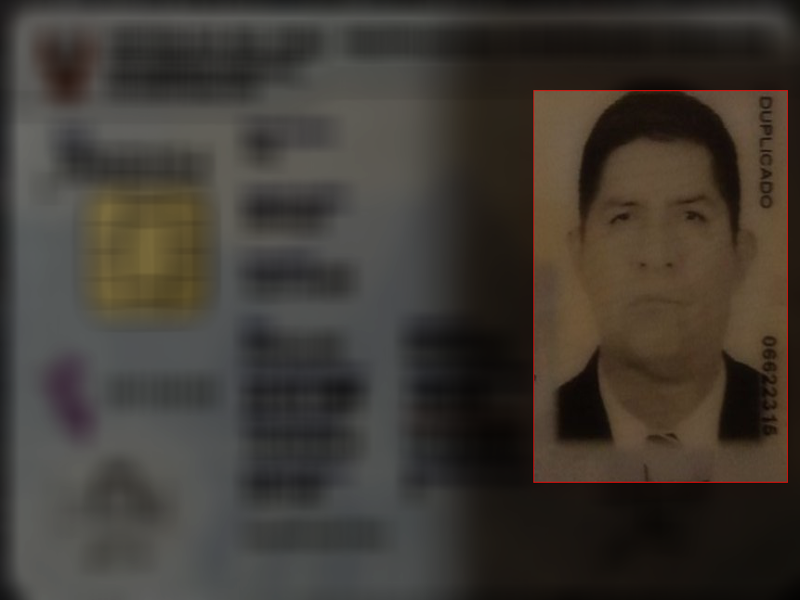

In [ ]:
print(os.path.join(path_data,'TRUE'))
procesar_imagenes(os.path.join(path_data,'TRUE'))

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE
ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-23.xml
tree
106 871 517 1397
106 871 517 1397
<class 'PIL.Image.Image'>


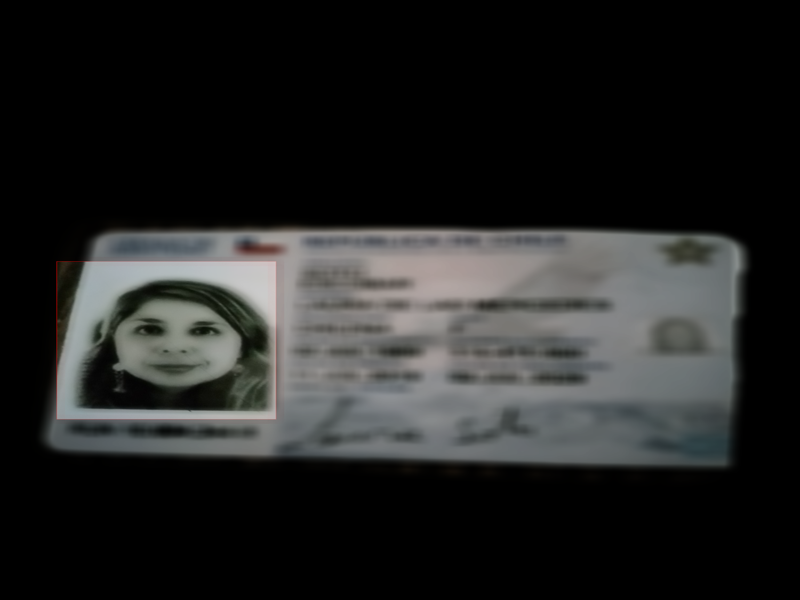

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_747.xml
tree
1101 255 1948 1119
1101 255 1948 1119
<class 'PIL.Image.Image'>


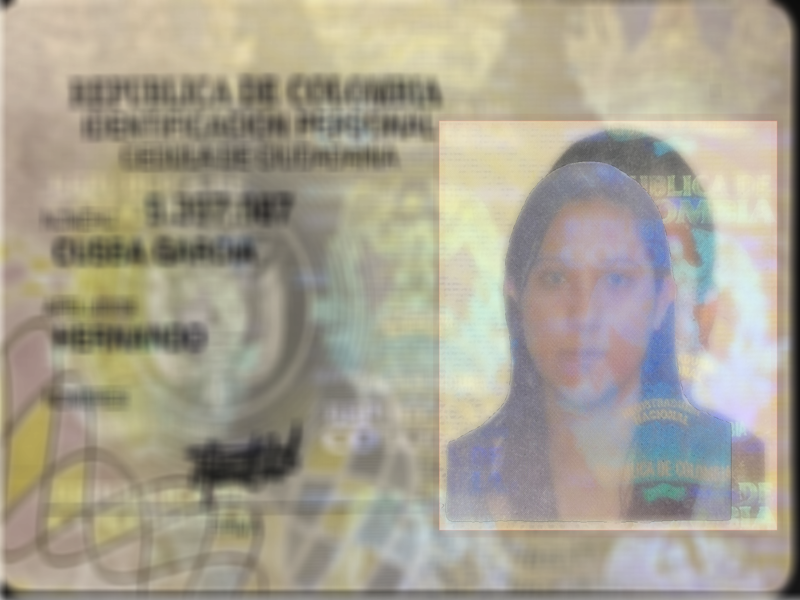

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-17.xml
tree
262 1141 643 1565
262 1141 643 1565
<class 'PIL.Image.Image'>


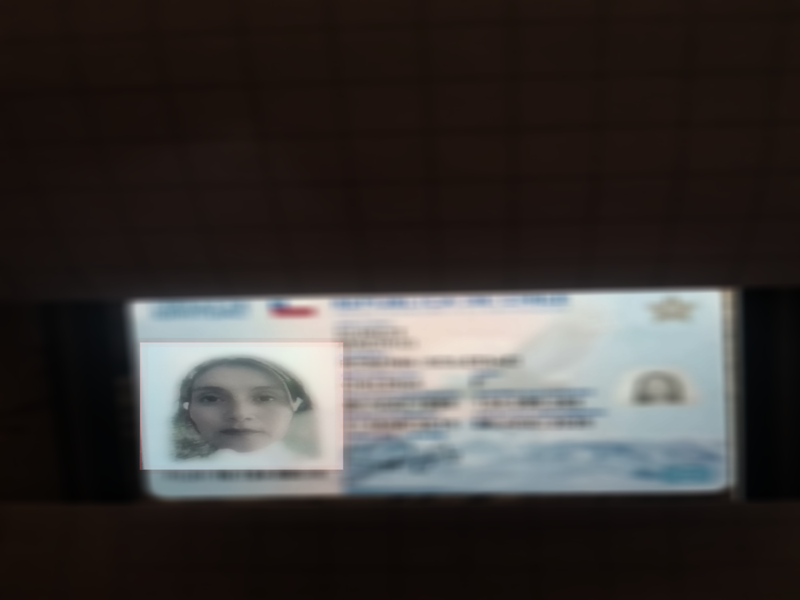

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2471.xml
tree
35 170 512 807
35 170 512 807
<class 'PIL.Image.Image'>


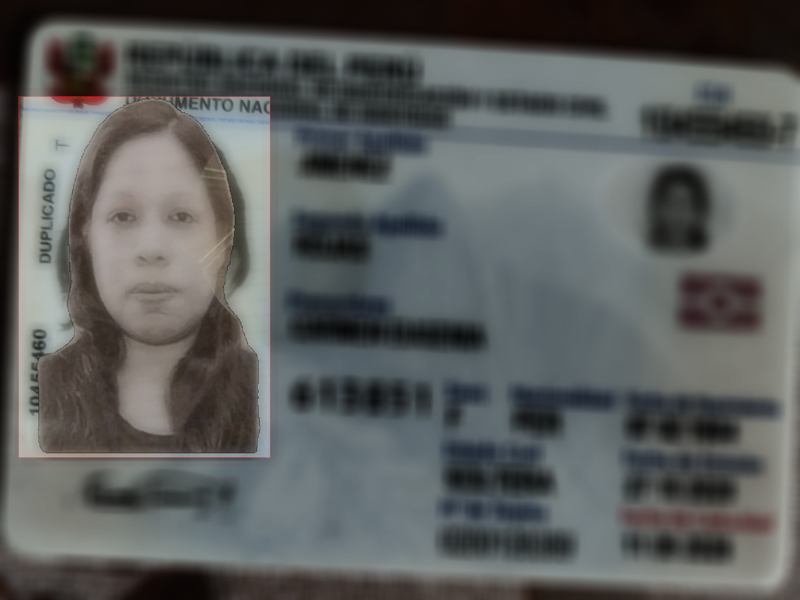

ingresa /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_267.xml
tree
610 132 1055 625
610 132 1055 625
<class 'PIL.Image.Image'>


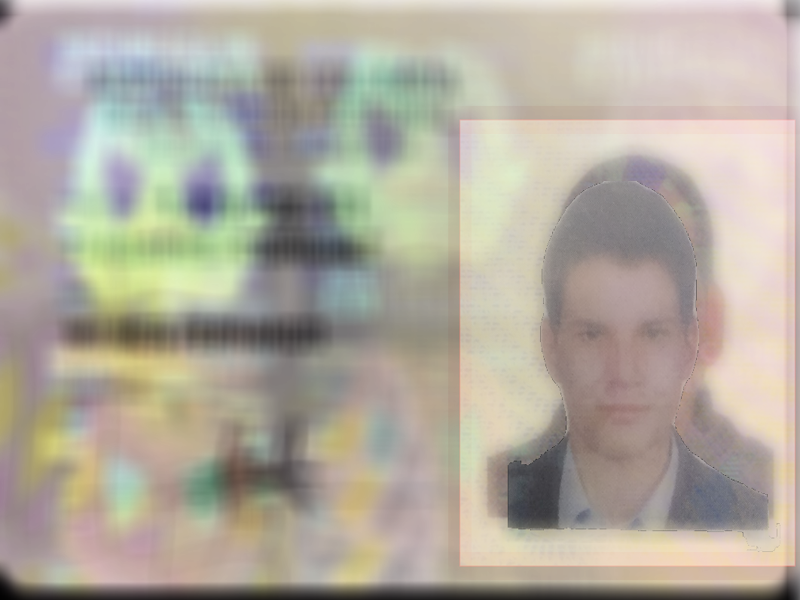

In [ ]:
print(os.path.join(path_data,'FALSE'))
procesar_imagenes(os.path.join(path_data,'FALSE'))

In [6]:
import os
import cv2
import argparse
from lxml import etree
import xml.etree.ElementTree as ET
from tqdm import tqdm
import subprocess
%cd /content/drive/MyDrive/DIPLOMADO/DATA-SUPER

def generateDict(input_path):
    dict_imgs = dict()
    for file_i in os.listdir(input_path):
        if '.ini' in file_i:
            continue
        if 'DS_Store' in file_i:
            continue
        if '.xml' not in file_i:
            img_lst_i = file_i.split('.')
            if len(img_lst_i) == 2:
                name_img_i,formato_img_i = img_lst_i[0], img_lst_i[1]
            else:
                name_img_i, formato_img_i = ".".join(img_lst_i[:len(img_lst_i)-1]), img_lst_i[len(img_lst_i)-1]
            dict_imgs[name_img_i]=formato_img_i
    return dict_imgs

def get_region_coordinates(xml_path):
    """
    Función que lee un archivo XML y devuelve las coordenadas de la región de interés.
    """
    # Parseamos el archivo xml para obtener las coordenadas de recorte
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    print(xmin, ymin, xmax, ymax)
    return xmin, ymin, xmax, ymax

def main_cut(dir, type_img):
    # directorio_actual = os.path.dirname(os.path.abspath(__file__))
    directorio_actual = ''
    print(directorio_actual)

    # Crea la carpeta cut si no existe
    os.makedirs(os.path.join(dir,"..", "..", "cut",type_img), exist_ok=True)
    input_path = os.path.join(os.getcwd(), dir)
    print(input_path)
    # os.makedirs(os.path.join(dir,"cut"), exist_ok=True)
    dict_imgs=generateDict(input_path)

    for name_i, formato_img_i in tqdm(dict_imgs.items(), total=len(dict_imgs)):
        if name_i != '':
    # for xml_file in xml_files:
        # Obtiene la ruta de la imagen correspondiente
            image_path = os.path.join(dir, name_i+'.'+formato_img_i)
            print(image_path)

            # Lee la imagen con OpenCV
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: could not load image {image_path}")
                continue

            # Obtiene las coordenadas de la región de interés
            print(os.path.join(dir, name_i))
            if not os.path.isfile(os.path.join(dir, name_i +".xml")):
                continue
            xmin, ymin, xmax, ymax = get_region_coordinates(os.path.join(dir, name_i +".xml"))
            print(xmin, ymin, xmax, ymax)
            # Recorta la imagen y guarda la imagen recortada en la carpeta cut
            try:
                if xmax-10 < image.shape[0] and   ymax-10 < image.shape[1]:
                    cut_image = image[ymin-10:ymax+10, xmin-15:xmax+15]
                else:
                    cut_image = image[ymin:ymax, xmin:xmax]
                print(os.path.join(dir,"..", "..", "cut",type_img, name_i + "."+ formato_img_i))
                cv2.imwrite(os.path.join(dir,"..", "..","cut",type_img, name_i + "."+ formato_img_i), cut_image)
            except:
                cut_image = image[ymin:ymax, xmin:xmax]
                cv2.imwrite(os.path.join(dir,"..", "..","cut",type_img, name_i + "."+ formato_img_i), cut_image)




/content/drive/MyDrive/DIPLOMADO/DATA-SUPER


In [ ]:
main_cut(os.path.join(path_data,'FALSE'),'FALSE')
main_cut(os.path.join(path_data,'TRUE'),'TRUE')



/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE


  0%|          | 1/238 [00:00<00:31,  7.53it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2342.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2342
13 258 632 1084
13 258 632 1084
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2342.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2341.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2341
30 121 323 480
30 121 323 480
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2341.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2325.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2325


  2%|▏         | 5/238 [00:00<00:38,  6.00it/s]

32 117 285 474
32 117 285 474
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2325.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2279.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2279
34 145 351 570
34 145 351 570
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2279.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2471.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2471
35 170 512 807
35 170 512 807
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2471.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2466.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2466
21 101 335 494
21 101 335 494
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2466.pn

  3%|▎         | 7/238 [00:01<00:32,  7.10it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2465.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2465
1 233 666 1203
1 233 666 1203
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2465.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2986.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2986
27 112 320 576
27 112 320 576
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2986.png


  5%|▍         | 11/238 [00:01<00:21, 10.46it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2982.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2982
11 135 386 670
11 135 386 670
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2982.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2936.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2936
22 121 296 506
22 121 296 506
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2936.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2227.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2227
885 261 1507 909
885 261 1507 909
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2227.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2000.png
/content/drive/MyDrive/DIPLOMADO/DATA-SU

  6%|▋         | 15/238 [00:01<00:21, 10.26it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2534.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2534
19 107 306 484
19 107 306 484
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2534.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_26.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_26
921 189 1773 1037
921 189 1773 1037
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_26.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2185.png


  7%|▋         | 17/238 [00:02<00:23,  9.42it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2185
6 328 678 1433
6 328 678 1433
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2185.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2176.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2176
24 219 500 929
24 219 500 929
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2176.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2174.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2174
6 113 312 576
6 113 312 576
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2174.png


  8%|▊         | 19/238 [00:02<00:19, 11.06it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2549.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2549
20 105 294 477
20 105 294 477
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2549.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2541.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2541
11 133 346 565
11 133 346 565
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2541.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2274.png


  9%|▉         | 21/238 [00:02<00:20, 10.52it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2274
79 450 650 1358
79 450 650 1358
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2274.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2418.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2418
20 105 278 433
20 105 278 433
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2418.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_24.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_24
42 407 683 1268
42 407 683 1268
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_24.png


 11%|█         | 25/238 [00:02<00:19, 10.84it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2064.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2064
16 143 357 630
16 143 357 630
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2064.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2007.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2007
1030 189 1752 955
1030 189 1752 955
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2007.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2580.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2580


 11%|█▏        | 27/238 [00:02<00:17, 11.76it/s]

28 143 390 606
28 143 390 606
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2580.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2553.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2553
21 176 481 766
21 176 481 766
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2553.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_274.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_274
632 128 1119 672
632 128 1119 672
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_274.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2702.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2702
15 122 292 462
15 122 292 462
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2702.p

 13%|█▎        | 31/238 [00:03<00:16, 12.55it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_267.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_267
610 132 1055 625
610 132 1055 625
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_267.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2200.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2200
1103 241 1744 1031
1103 241 1744 1031
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2200.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2199.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2199
1548 305 2561 1457
1548 305 2561 1457
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2199.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2104.png


 14%|█▍        | 33/238 [00:03<00:24,  8.29it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2104
1170 232 2016 1202
1170 232 2016 1202
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2104.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_25.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_25
9 103 324 508
9 103 324 508
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_25.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2479.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2479
42 155 493 738
42 155 493 738
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2479.png


 16%|█▌        | 37/238 [00:03<00:20,  9.93it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1912.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1912
26 110 337 589
26 110 337 589
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1912.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2004.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2004
1031 197 1763 1003
1031 197 1763 1003
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2004.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2472.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2472
28 112 390 548
28 112 390 548
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2472.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1999.png
/content/drive/MyDrive/DIPLOMADO/DAT

 17%|█▋        | 41/238 [00:04<00:19,  9.93it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_196.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_196
687 110 1103 540
687 110 1103 540
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_196.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1948.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1948
19 111 283 460
19 111 283 460
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1948.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1954.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1954
23 128 367 536
23 128 367 536
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1954.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1936.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER

 18%|█▊        | 43/238 [00:04<00:16, 11.64it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1914.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1914
847 141 1415 841
847 141 1415 841
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1914.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2209.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2209
1119 272 1743 1025
1119 272 1743 1025
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2209.png


 20%|█▉        | 47/238 [00:04<00:16, 11.62it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2159.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2159
1 110 323 577
1 110 323 577
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2159.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2149.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2149
1 80 275 451
1 80 275 451
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2149.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2352.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2352
23 119 298 466
23 119 298 466
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2352.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2005.png


 21%|██        | 49/238 [00:05<00:18, 10.49it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2005
1018 181 1776 949
1018 181 1776 949
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2005.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-22.png


 21%|██▏       | 51/238 [00:05<00:21,  8.86it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-22
37 1000 529 1584
37 1000 529 1584
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-22.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-21.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-21
95 712 537 1237
95 712 537 1237
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-21.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-21-2.png


 22%|██▏       | 53/238 [00:05<00:21,  8.67it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-21-2
51 182 421 722
51 182 421 722
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-21-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-20.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-20
51 916 529 1575
51 916 529 1575
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-20.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1676.png


 23%|██▎       | 54/238 [00:05<00:21,  8.58it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1676
30 217 479 853
30 217 479 853
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1676.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1650.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1650
20 113 285 483
20 113 285 483
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1650.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1672.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1672
16 111 269 460
16 111 269 460
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1672.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_10.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_10
591 98 949 481
591 98 949 481
/content/drive/MyDrive

 24%|██▍       | 57/238 [00:05<00:16, 11.27it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-11.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-11
118 774 615 1406
118 774 615 1406
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-11.png


 25%|██▍       | 59/238 [00:06<00:20,  8.71it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-11-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-11-2
32 181 609 918
32 181 609 918
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-11-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-10.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-10
184 434 845 1235
184 434 845 1235
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-10.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-18.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-18
55 487 539 1082

 26%|██▋       | 63/238 [00:06<00:21,  8.24it/s]


55 487 539 1082
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-18.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-18-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-18-2
17 152 461 741
17 152 461 741
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-18-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-31-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-31-2
28 117 321 529
28 117 321 529
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-31-2.png


 27%|██▋       | 64/238 [00:06<00:22,  7.64it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-30.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-30
8 512 482 1179
8 512 482 1179
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-30.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-30-2.png


 28%|██▊       | 67/238 [00:07<00:17,  9.86it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-30-2
1 196 448 904
1 196 448 904
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-30-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1885.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1885
30 127 341 541
30 127 341 541
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1885.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1879.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1879
24 105 316 473
24 105 316 473
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1879.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1814.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1814
13 144 349 635
13 144 349 635
/content/drive/MyDrive/DIPLOMADO

 30%|██▉       | 71/238 [00:07<00:13, 12.35it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1715.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1715
627 152 1044 605
627 152 1044 605
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1715.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1756.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1756
22 114 314 496
22 114 314 496
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1756.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1713.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1713
524 132 907 531
524 132 907 531
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1713.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-26.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DA

 31%|███       | 73/238 [00:07<00:15, 10.68it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-25.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-25
156 366 754 1204
156 366 754 1204
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-25.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-24.png


 32%|███▏      | 75/238 [00:08<00:19,  8.33it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-24
50 682 557 1360
50 682 557 1360
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-24.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-9.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-9
1 659 556 1417
1 659 556 1417
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-9.png


 32%|███▏      | 77/238 [00:08<00:21,  7.66it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-9-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-9-2
1 216 545 920
1 216 545 920
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-9-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-8.png


 33%|███▎      | 79/238 [00:08<00:21,  7.55it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-8
166 948 622 1469
166 948 622 1469
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-8.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1190.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1190
847 142 1407 820
847 142 1407 820
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1190.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1185.png


 34%|███▎      | 80/238 [00:09<00:32,  4.84it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1185
1937 556 3162 1869
1937 556 3162 1869
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1185.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A_11803361_Fecha27-09-2022_11-05-13.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A_11803361_Fecha27-09-2022_11-05-13
437 103 800 556
437 103 800 556
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A_11803361_Fecha27-09-2022_11-05-13.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A20210726_081948.jpg


 34%|███▍      | 82/238 [00:09<00:34,  4.49it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A20210726_081948
2246 1039 3668 2504
2246 1039 3668 2504
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A20210726_081948.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A20210726_081925.jpg


 35%|███▍      | 83/238 [00:09<00:39,  3.89it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A20210726_081925
2230 766 3640 2370
2230 766 3640 2370
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A20210726_081925.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A1_52818765.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A1_52818765
525 133 913 526
525 133 913 526
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A1_52818765.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A1_1022437504.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A1_1022437504
529 67 1028 648
529 67 1028 648
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A1_1022437504.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1260.png


 37%|███▋      | 88/238 [00:10<00:19,  7.66it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1260
937 108 1404 677
937 108 1404 677
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1260.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1246.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1246
4 119 340 606
4 119 340 606
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1246.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1240.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1240
626 109 935 484
626 109 935 484
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1240.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1233.png


 39%|███▊      | 92/238 [00:10<00:13, 11.02it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1233
641 95 959 479
641 95 959 479
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1233.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1232.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1232
785 109 1160 552
785 109 1160 552
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1232.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/8302888_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/8302888_A
618 123 957 536
618 123 957 536
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/8302888_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/77008429_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/77008429_A
557 131 897 516
557 131 897 516
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE

 39%|███▉      | 94/238 [00:10<00:13, 10.57it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/66944226_A
511 98 928 553
511 98 928 553
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/66944226_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_16.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_16
989 157 1800 1028
989 157 1800 1028
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_16.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1524.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1524
135 496 710 1181
135 496 710 1181
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1524.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1429.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1429
19 335 683 1260
19 335 683 1260
/content/drive/MyDrive/DIPLOMA

 41%|████      | 98/238 [00:11<00:14,  9.68it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1348.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1348
617 89 892 441
617 89 892 441
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1348.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-6.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-6
37 542 486 1121
37 542 486 1121
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-6.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-17.png


 42%|████▏     | 100/238 [00:11<00:13, 10.24it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-17
262 1141 643 1565
262 1141 643 1565
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-17.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-17-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-17-2
51 175 405 609
51 175 405 609
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-17-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-16.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-16
169 552 790 1313
169 552 790 1313
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-16.png


 43%|████▎     | 102/238 [00:11<00:13, 10.12it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-14-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-14-2
43 159 417 603
43 159 417 603
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-14-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-13.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-13
198 738 649 1426
198 738 649 1426
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-13.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-12.png


 44%|████▎     | 104/238 [00:11<00:14,  9.05it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-12
29 665 535 1271
29 665 535 1271
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-12.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-12-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-12-2
30 170 516 785
30 170 516 785
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-12-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-29.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-29
29 159 470 802
29 159 470 802
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-29.png


 45%|████▍     | 106/238 [00:11<00:13,  9.81it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-28.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-28
63 724 539 1387
63 724 539 1387
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-28.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-28-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-28-2
31 169 492 850
31 169 492 850
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-28-2.png


 46%|████▌     | 110/238 [00:12<00:11, 10.96it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-27.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-27
27 172 337 570
27 172 337 570
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-27.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-5-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-5-2
20 125 457 680
20 125 457 680
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-5-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-35.png


 47%|████▋     | 112/238 [00:12<00:12,  9.80it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-35
43 796 503 1387
43 796 503 1387
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-35.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1699.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1699
1048 182 1744 1018
1048 182 1744 1018
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1699.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-15-2.png


 48%|████▊     | 114/238 [00:12<00:12,  9.80it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-15-2
11 196 464 807
11 196 464 807
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-15-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-14.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-14
50 474 421 952
50 474 421 952
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-14.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1A20210726_081948.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1A20210726_081948
2202 1053 3616 2539
2202 1053 3616 2539
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/1A20210726_081948.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1A20210726_081925.jpg


 49%|████▊     | 116/238 [00:13<00:22,  5.36it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1A20210726_081925
2179 676 3695 2428
2179 676 3695 2428
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/1A20210726_081925.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/19OCT_A1_1022402209-20221019-202853.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/19OCT_A1_1022402209-20221019-202853
544 105 947 595
544 105 947 595
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/19OCT_A1_1022402209-20221019-202853.JPEG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/16. 19455648_A_19082021_155639.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/16. 19455648_A_19082021_155639
715 156 1113 645
715 156 1113 645
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/16. 19455648_A_19082021_155639.png


 50%|█████     | 120/238 [00:13<00:13,  8.50it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1065641027_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1065641027_A
566 112 941 546
566 112 941 546
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/1065641027_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A-image-20221021-165900.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/A-image-20221021-165900
498 70 921 580
498 70 921 580
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/A-image-20221021-165900.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1224.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1224
29 191 453 818
29 191 453 818
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1224.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1219.png


 51%|█████▏    | 122/238 [00:13<00:13,  8.39it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1219
13 406 635 1350
13 406 635 1350
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1219.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1174.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1174
819 207 1381 777
819 207 1381 777
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1174.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-24-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-24-2
55 206 561 893
55 206 561 893
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-24-2.png


 53%|█████▎    | 126/238 [00:14<00:11,  9.87it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-23.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-23
106 871 517 1397
106 871 517 1397
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-23.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-23-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-23-2
63 164 487 687
63 164 487 687
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-23-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/6. 19455648_A_19082021_155639.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/6. 19455648_A_19082021_155639
692 147 1126 637
692 147 1126 637
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/6. 19455648_A_19082021_155639.png


 55%|█████▍    | 130/238 [00:14<00:08, 12.65it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/5889456_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/5889456_A
595 159 995 605
595 159 995 605
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/5889456_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/43020140_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/43020140_A
549 94 992 564
549 94 992 564
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/43020140_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/41944116_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/41944116_A
531 177 917 575
531 177 917 575
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/41944116_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1305.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1305
626 66 925 457
626 66 925 457
/content/drive/

 55%|█████▌    | 132/238 [00:14<00:07, 14.12it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1297.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1297
7 111 283 457
7 111 283 457
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1297.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1291.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1291
14 132 355 651
14 132 355 651
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1291.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-10-2.png


 56%|█████▋    | 134/238 [00:14<00:08, 12.53it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-10-2
24 223 650 1015
24 223 650 1015
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-10-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-1.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-1
31 1223 537 1850
31 1223 537 1850
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-1.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-1-2.png


 57%|█████▋    | 136/238 [00:15<00:08, 11.45it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-1-2
78 132 489 801
78 132 489 801
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-1-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-20-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-20-2
79 231 545 837
79 231 545 837
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-20-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-19.png


 59%|█████▉    | 140/238 [00:15<00:08, 11.40it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-19
84 1142 449 1669
84 1142 449 1669
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-19.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-19-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-19-2
55 199 469 750
55 199 469 750
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-19-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-8-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-8-2
69 157 487 683
69 157 487 683
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-8-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-7.png


 60%|█████▉    | 142/238 [00:15<00:09,  9.88it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-7
107 459 742 1252
107 459 742 1252
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-7.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-7-7.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-7-7
52 261 631 997
52 261 631 997
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-7-7.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-16-2.png


 61%|██████    | 144/238 [00:15<00:09, 10.00it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-16-2
70 253 650 1022
70 253 650 1022
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-16-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1154.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1154
17 141 371 651
17 141 371 651
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1154.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_108.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_108
543 113 839 466
543 113 839 466
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_108.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1027.png


 61%|██████▏   | 146/238 [00:16<00:07, 11.55it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1027
20 121 328 500
20 121 328 500
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1027.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/34598246_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/34598246_A
528 115 936 556
528 115 936 556
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/34598246_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/3408937_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/3408937_A
633 185 1038 605
633 185 1038 605
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/3408937_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/212073555.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/212073555
1 1070 508 1697
1 1070 508 1697
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/212073555.jp

 63%|██████▎   | 151/238 [00:16<00:06, 12.76it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/212073555-2.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/212073555-2
1 190 496 790
1 190 496 790
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/212073555-2.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-35-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-35-2
10 196 502 796
10 196 502 796
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-35-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-34-2.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-34-2
6 198 449 791
6 198 449 791
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-34-2.png


 65%|██████▌   | 155/238 [00:16<00:06, 13.58it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1035853025_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/1035853025_A
562 88 1002 555
562 88 1002 555
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/1035853025_A.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-31.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/20230302-31
211 809 519 1237
211 809 519 1237
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/20230302-31.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1265.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_1265
606 86 921 459
606 86 921 459
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_1265.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3712.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3712
94 3

 66%|██████▌   | 157/238 [00:16<00:07, 10.91it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_368
994 420 1755 1144
994 420 1755 1144
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_368.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3679.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3679
78 334 628 969
78 334 628 969
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3679.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3649.png


 67%|██████▋   | 159/238 [00:17<00:08,  9.75it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3649
148 452 664 1167
148 452 664 1167
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3649.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4547.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4547
7 108 298 516
7 108 298 516
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4547.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4561.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4561
3 112 319 531
3 112 319 531
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4561.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4541.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4541
5 129 401 672
5 129 401 672
/content/drive/MyDri

 68%|██████▊   | 162/238 [00:17<00:06, 12.09it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_446.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_446
472 111 889 529
472 111 889 529
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_446.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_445.png


 69%|██████▉   | 164/238 [00:17<00:09,  8.00it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_445
2046 824 3404 2408
2046 824 3404 2408
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_445.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_364.png


 70%|██████▉   | 166/238 [00:18<00:08,  8.40it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_364
1024 286 1799 1097
1024 286 1799 1097
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_364.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4422.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4422
16 96 284 476
16 96 284 476
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4422.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4404.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4404
26 129 359 592
26 129 359 592
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4404.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4819.png


 71%|███████▏  | 170/238 [00:18<00:06, 10.35it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4819
1 117 371 600
1 117 371 600
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4819.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4811.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4811
1 90 271 480
1 90 271 480
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4811.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4800.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4800
35 168 555 871
35 168 555 871
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4800.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4784.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4784
1 96 324 523
1 96 324 523
/content/drive/MyDrive/DIPLO

 74%|███████▎  | 175/238 [00:18<00:05, 10.74it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4675.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4675
29 185 579 983
29 185 579 983
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4675.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4672.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4672
10 95 286 513
10 95 286 513
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4672.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_5.png


 74%|███████▍  | 177/238 [00:19<00:07,  8.68it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_5
1462 398 2538 1712
1462 398 2538 1712
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_5.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_498.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_498
14 104 344 530
14 104 344 530
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_498.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_497.png


 76%|███████▌  | 180/238 [00:19<00:05,  9.91it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_497
3 236 742 1177
3 236 742 1177
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_497.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3404.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3404
7 151 350 632
7 151 350 632
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3404.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3118.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3118
26 114 328 560
26 114 328 560
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3118.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3042.png


 76%|███████▋  | 182/238 [00:19<00:05, 10.92it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3042
24 125 383 650
24 125 383 650
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3042.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3036.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3036
35 146 426 743
35 146 426 743
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3036.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3029.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3029
33 155 378 647
33 155 378 647
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3029.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3024.png


 77%|███████▋  | 184/238 [00:19<00:05,  9.65it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3024
118 432 706 1375
118 432 706 1375
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3024.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4076.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4076
31 102 344 490
31 102 344 490
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4076.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4070.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4070

 78%|███████▊  | 186/238 [00:19<00:05,  9.80it/s]


54 199 534 842
54 199 534 842
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4070.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4064.png


 79%|███████▉  | 188/238 [00:20<00:05,  8.64it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4064
14 207 695 1175
14 207 695 1175
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4064.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4063.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4063
31 118 321 495
31 118 321 495
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4063.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4051.png


 80%|████████  | 191/238 [00:20<00:04, 10.33it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4051
27 221 511 967
27 221 511 967
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4051.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4117.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4117
16 68 256 379
16 68 256 379
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4117.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4186.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4186
12 98 298 465
12 98 298 465
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4186.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4116.png


 81%|████████  | 193/238 [00:20<00:03, 11.32it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4116
34 97 339 515
34 97 339 515
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4116.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_983.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_983
13 176 381 702
13 176 381 702
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_983.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_82.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_82
700 112 1195 619
700 112 1195 619
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_82.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_76.png


 82%|████████▏ | 195/238 [00:20<00:03, 12.13it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_76
483 64 770 396
483 64 770 396
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_76.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_358.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_358
23 169 450 657
23 169 450 657
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_358.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3556.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3556
46 165 480 844
46 165 480 844
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3556.png


 84%|████████▎ | 199/238 [00:21<00:03, 11.81it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3493.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3493
20 118 324 510
20 118 324 510
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3493.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3468.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3468
33 132 398 688
33 132 398 688
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3468.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_747.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_747
1101 255 1948 1119
1101 255 1948 1119
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_747.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_738.png
/content/drive/MyDrive/DIPLOMADO/DATA-SU

 84%|████████▍ | 201/238 [00:21<00:04,  8.18it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_737.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_737
981 260 1764 998
981 260 1764 998
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_737.png


 85%|████████▌ | 203/238 [00:21<00:04,  7.45it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4868.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4868
1 101 327 521
1 101 327 521
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4868.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4838.png


 86%|████████▌ | 204/238 [00:22<00:04,  6.84it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4838
57 342 652 1241
57 342 652 1241
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4838.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4115.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4115
33 125 461 694
33 125 461 694
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4115.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4108.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4108
20 189 434 710
20 189 434 710
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4108.png


 87%|████████▋ | 208/238 [00:22<00:03,  9.65it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4098.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4098
31 79 276 399
31 79 276 399
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4098.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4087.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4087
32 116 379 559
32 116 379 559
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4087.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3456.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3456
23 126 393 668
23 126 393 668
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3456.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3455.png


 88%|████████▊ | 210/238 [00:22<00:02,  9.79it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3455
39 202 514 984
39 202 514 984
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3455.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3448.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3448
30 116 333 596
30 116 333 596
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3448.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_750.png


 89%|████████▉ | 212/238 [00:22<00:02,  9.21it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_750
956 251 1686 1004
956 251 1686 1004
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_750.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3
596 94 977 580
596 94 977 580
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_400.png


 90%|█████████ | 215/238 [00:23<00:02,  9.06it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_400
993 379 1650 1051
993 379 1650 1051
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_400.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_733.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_733
9 154 373 586
9 154 373 586
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_733.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_717.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_717
3 112 291 480
3 112 291 480
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_717.png


 92%|█████████▏| 219/238 [00:23<00:01, 11.59it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_673.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_673
8 77 254 371
8 77 254 371
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_673.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_661.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_661
1 108 439 648
1 108 439 648
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_661.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_639.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_639
1 98 394 570
1 98 394 570
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_639.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_632.png


 93%|█████████▎| 221/238 [00:23<00:01, 12.47it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_632
1 91 336 457
1 91 336 457
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_632.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_621.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_621
3 86 349 467
3 86 349 467
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_621.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_517.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_517
39 162 482 755
39 162 482 755
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_517.png


 94%|█████████▎| 223/238 [00:23<00:01, 10.08it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_398.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_398
928 235 1759 1081
928 235 1759 1081
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_398.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_665.png


 95%|█████████▍| 225/238 [00:23<00:01, 11.02it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_665
19 153 431 646
19 153 431 646
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_665.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2991.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_2991
17 94 280 500
17 94 280 500
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_2991.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_503.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_503
28 184 568 889
28 184 568 889
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_503.png


 95%|█████████▌| 227/238 [00:24<00:01, 10.76it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_5025.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_5025
1 98 294 490
1 98 294 490
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_5025.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3946.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3946

 96%|█████████▌| 229/238 [00:24<00:00,  9.63it/s]


89 796 559 1371
89 796 559 1371
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3946.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_39.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_39
1 96 359 531
1 96 359 531
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_39.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3897.png


 98%|█████████▊| 233/238 [00:24<00:00, 11.81it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3897
168 826 517 1313
168 826 517 1313
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3897.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3871.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3871
24 118 321 605
24 118 321 605
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3871.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3858.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3858
33 189 372 707
33 189 372 707
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_3858.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3791.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_3791
33 136 346 649
33 136 346 649
/content/drive

 99%|█████████▊| 235/238 [00:25<00:00,  7.35it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_436
1809 650 3392 2061
1809 650 3392 2061
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_436.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4358.png

100%|█████████▉| 237/238 [00:25<00:00,  8.26it/s]


/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4358
22 153 427 680
22 153 427 680
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4358.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_431.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_431
763 214 1366 811
763 214 1366 811
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_431.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4233.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/combined_image_4233


100%|██████████| 238/238 [00:25<00:00,  9.36it/s]


7 163 409 719
7 163 409 719
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE/../../cut/FALSE/combined_image_4233.png

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE


  0%|          | 0/248 [00:00<?, ?it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06765651.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06765651
637 88 968 495
637 88 968 495
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/06765651.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06622315.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06622315
574 83 847 444
574 83 847 444
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/06622315.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06341626F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06341626F


  2%|▏         | 5/248 [00:00<00:32,  7.52it/s]

120 362 634 1011
120 362 634 1011
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/06341626F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/05804f9e-57b7-4d41-a751-4da2fab2fc71F.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/05804f9e-57b7-4d41-a751-4da2fab2fc71F
102 920 510 1447
102 920 510 1447
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/05804f9e-57b7-4d41-a751-4da2fab2fc71F.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06047540F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/06047540F
87 283 646 1009
87 283 646 1009
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/06047540F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/03302080F.JPG


  3%|▎         | 7/248 [00:00<00:24,  9.88it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/03302080F
972 1086 1454 1650
972 1086 1454 1650
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/03302080F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/02898645.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/02898645
0 104 314 456
0 104 314 456
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/02898645.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/02861860.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/02861860
616 77 921 474
616 77 921 474
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/02861860.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/25563976.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/25563976
19 85 270 422
19 85 270 422
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/25563976.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_

  6%|▌         | 15/248 [00:01<00:13, 17.66it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/23924650.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/23924650
585 68 859 447
585 68 859 447
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/23924650.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42774356.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42774356
24 144 466 698
24 144 466 698
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42774356.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42746891.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42746891
22 96 317 469
22 96 317 469
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42746891.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42738146.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42738146
269 1005 606 1432
269 1005 606 1432
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cu

  7%|▋         | 18/248 [00:01<00:13, 16.68it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15243247K
152 789 543 1321
152 789 543 1321
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/15243247K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15004197K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15004197K
13 117 295 490
13 117 295 490
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/15004197K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43204194F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43204194F
992 813 1398 1360
992 813 1398 1360
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43204194F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12224783kF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12224783kF
20 118 311 496
20 118 311 496
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/12224783kF.jpeg
/content/drive/MyDrive/DIPLO

  9%|▉         | 22/248 [00:01<00:12, 18.53it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10897964k
9 131 249 440
9 131 249 440
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10897964k.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10856878K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10856878K
239 520 764 1218
239 520 764 1218
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10856878K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12224783k.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12224783k
7 120 319 516
7 120 319 516
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/12224783k.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/11895937K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/11895937K
14 104 295 463
14 104 295 463
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/11895937K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-S

 11%|█▏        | 28/248 [00:01<00:11, 19.02it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09600187
973 809 1363 1336
973 809 1363 1336
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/09600187.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09394618.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09394618
1300 337 1922 1179
1300 337 1922 1179
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/09394618.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40341010.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40341010
1147 155 1698 845
1147 155 1698 845
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/40341010.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10159310K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10159310K
29 131 361 545
29 131 361 545
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10159310K.jpg
/content/drive/MyDrive/DIPLOMADO

 12%|█▎        | 31/248 [00:01<00:10, 20.83it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/19478841K
15 106 271 427
15 106 271 427
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/19478841K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13822998K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13822998K
25 128 305 515
25 128 305 515
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13822998K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16675517.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16675517
27 96 285 414
27 96 285 414
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/16675517.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42044625.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42044625
1 111 329 491
1 111 329 491
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42044625.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/T

 15%|█▍        | 37/248 [00:02<00:10, 19.69it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40189752F2
67 822 535 1434
67 822 535 1434
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/40189752F2.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41461277.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41461277
2 90 282 399
2 90 282 399
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41461277.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41480688.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41480688
15 98 310 478
15 98 310 478
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41480688.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41284945.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41284945
76 901 509 1402
76 901 509 1402
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41284945.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/

 16%|█▌        | 40/248 [00:02<00:10, 19.27it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10770879
886 170 1310 698
886 170 1310 698
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10770879.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10738627.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10738627
23 208 634 997
23 208 634 997
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10738627.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16661368K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16661368K
2 124 282 483
2 124 282 483
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/16661368K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (54).png


 17%|█▋        | 42/248 [00:02<00:13, 14.98it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (54)
262 322 749 967
262 322 749 967
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (54).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (52).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (52)
94 934 498 1470
94 934 498 1470
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (52).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (46).png


 18%|█▊        | 44/248 [00:02<00:16, 12.47it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (46)
965 714 1354 1246
965 714 1354 1246
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (46).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (45).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (45)
193 863 555 1332
193 863 555 1332
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (45).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75711529.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75711529


 19%|█▊        | 46/248 [00:03<00:15, 12.78it/s]

50 271 676 1120
50 271 676 1120
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/75711529.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76652113.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76652113
255 693 603 1080
255 693 603 1080
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/76652113.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76172498F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76172498F
18 106 305 523
18 106 305 523
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/76172498F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76091392.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76091392
25 133 326 482
25 133 326 482
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/76091392.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76355183.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SU

 21%|██        | 52/248 [00:03<00:11, 16.52it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75876114F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75876114F
3 135 354 524
3 135 354 524
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/75876114F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75218338f.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75218338f
45 442 501 1043
45 442 501 1043
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/75218338f.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73532000F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73532000F
166 292 549 828
166 292 549 828
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/73532000F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72917549.jpg


 22%|██▏       | 54/248 [00:03<00:11, 16.69it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72917549
1307 450 1829 1125
1307 450 1829 1125
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72917549.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73089693.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73089693
9 115 367 533
9 115 367 533
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/73089693.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72885693.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72885693
27 112 326 469
27 112 326 469
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72885693.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73034242.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73034242
742 107 1110 527
742 107 1110 527
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/73034242.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/D

 24%|██▍       | 60/248 [00:03<00:11, 16.93it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/89365686F
848 1031 1645 2054
848 1031 1645 2054
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/89365686F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/86577348F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/86577348F
12 101 325 498
12 101 325 498
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/86577348F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/7723492.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/7723492
572 657 887 1052
572 657 887 1052
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/7723492.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/83204389F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/83204389F
10 116 318 511
10 116 318 511
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/83204389F.jpeg
/content/drive/MyDrive/DIPLOMADO/

 26%|██▌       | 64/248 [00:04<00:10, 18.00it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/76968797
2 92 296 455
2 92 296 455
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/76968797.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front-23.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front-23
190 815 500 1223
190 815 500 1223
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front-23.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (56).png


 27%|██▋       | 66/248 [00:04<00:12, 14.46it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (56)
1428 400 1984 1198
1428 400 1984 1198
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (56).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (55).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (55)
150 477 674 1202
150 477 674 1202
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (55).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74840263.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74840263
708 80 1043 518
708 80 1043 518
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74840263.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74693077.jpg


 28%|██▊       | 69/248 [00:04<00:11, 16.00it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74693077
7 118 352 513
7 118 352 513
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74693077.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74061955.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74061955
194 398 682 1060
194 398 682 1060
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74061955.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74802808.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74802808
27 94 296 407
27 94 296 407
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74802808.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74629989F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74629989F
32 152 382 624
32 152 382 624
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74629989F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_O

 30%|██▉       | 74/248 [00:04<00:11, 15.67it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/74060660
295 458 725 1015
295 458 725 1015
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/74060660.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73866518.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/73866518
635 101 946 496
635 101 946 496
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/73866518.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/ea88f5c96672edb4truetrue1541777156491ADR1541777550210.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/ea88f5c96672edb4truetrue1541777156491ADR1541777550210
1253 145 1707 797
1253 145 1707 797
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/ea88f5c96672edb4truetrue1541777156491ADR1541777550210.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10415590.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10415590
67 176 549 772

 32%|███▏      | 79/248 [00:05<00:12, 13.40it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10684520
29 168 501 746
29 168 501 746
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/copy_10684520.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10316273.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_10316273
29 167 519 703
29 167 519 703
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/copy_10316273.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_06341626.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_06341626
32 155 494 709
32 155 494 709
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/copy_06341626.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44833067.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44833067
104 722 498 1252
104 722 498 1252
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44833067.jpg


 33%|███▎      | 81/248 [00:05<00:12, 13.86it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44671473.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44671473
953 1209 1306 1710
953 1209 1306 1710
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44671473.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44538828.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44538828
10 142 406 564
10 142 406 564
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44538828.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44529215.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44529215
662 83 984 499
662 83 984 499
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44529215.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44631922.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44631922
41 116 399 568
41 116 399 568
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../.

 35%|███▍      | 86/248 [00:05<00:10, 15.47it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44231576.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44231576
564 75 871 443
564 75 871 443
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44231576.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (36).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (36)
179 870 531 1349
179 870 531 1349
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (36).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (35).png


 35%|███▌      | 88/248 [00:05<00:11, 13.69it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (35)
56 797 467 1365
56 797 467 1365
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (35).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45296365.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45296365
167 390 690 1041
167 390 690 1041
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45296365.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44868072.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44868072
612 59 934 476
612 59 934 476
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44868072.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45198843.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45198843
26 92 297 439
26 92 297 439
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45198843.jpg


 38%|███▊      | 93/248 [00:06<00:09, 16.24it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44869583.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44869583
21 108 314 439
21 108 314 439
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/44869583.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45321112.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45321112
20 96 316 467
20 96 316 467
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45321112.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45008479_.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45008479_
107 1062 485 1558
107 1062 485 1558
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45008479_.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44867770.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/44867770
73 889 454 1411
73 889 454 1411
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../

 39%|███▊      | 96/248 [00:06<00:08, 18.46it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46099533.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46099533
5 86 304 460
5 86 304 460
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/46099533.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45702921.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45702921
13 89 300 444
13 89 300 444
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45702921.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45930364.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45930364
129 711 621 1334
129 711 621 1334
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45930364.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45681531.png


 40%|███▉      | 98/248 [00:06<00:09, 15.11it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45681531
250 922 549 1247
250 922 549 1247
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45681531.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45681531-1.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45681531-1
108 869 501 1359
108 869 501 1359
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45681531-1.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45619720.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45619720
15 95 307 485
15 95 307 485
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45619720.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45599130.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/45599130
100 808 527 1345
100 808 527 1345
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/45599130.jpg


 42%|████▏     | 105/248 [00:06<00:07, 19.62it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72393625.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72393625
507 32 762 374
507 32 762 374
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72393625.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72452271.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72452271
16 102 315 476
16 102 315 476
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72452271.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72506499F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72506499F
25 114 345 551
25 114 345 551
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72506499F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72433316.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72433316
514 71 767 390
514 71 767 390
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../c

 44%|████▎     | 108/248 [00:06<00:07, 19.75it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72381817
134 486 568 1024
134 486 568 1024
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72381817.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72020031.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72020031
722 89 1069 534
722 89 1069 534
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72020031.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/47941863.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/47941863
758 98 1136 555
758 98 1136 555
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/47941863.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46989623.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46989623
542 69 821 420
542 69 821 420
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/46989623.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DAT

 46%|████▋     | 115/248 [00:07<00:06, 21.03it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/47246970.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/47246970
625 71 934 465
625 71 934 465
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/47246970.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46776370.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46776370
69 263 665 1015
69 263 665 1015
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/46776370.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46207584.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/46207584
19 103 309 452
19 103 309 452
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/46207584.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/67759400F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/67759400F
158 874 589 1415
158 874 589 1415
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../

 48%|████▊     | 118/248 [00:07<00:08, 14.93it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/65906864F
183 493 706 1124
183 493 706 1124
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/65906864F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/65329832F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/65329832F
19 113 347 539
19 113 347 539
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/65329832F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/65232308F.jpeg


 48%|████▊     | 120/248 [00:08<00:15,  8.21it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/65232308F
2245 2135 3585 3843
2245 2135 3585 3843
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/65232308F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/63201146F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/63201146F
19 133 391 596
19 133 391 596
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/63201146F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/6221192KF.jpeg


 49%|████▉     | 122/248 [00:08<00:14,  8.41it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/6221192KF
626 961 1399 2143
626 961 1399 2143
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/6221192KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (44).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (44)
83 824 481 1356
83 824 481 1356
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (44).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (41).png


 50%|█████     | 124/248 [00:08<00:14,  8.47it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (41)
37 998 517 1571
37 998 517 1571
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (41).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (39).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (39)
929 637 1323 1154
929 637 1323 1154
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (39).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (38).png


 51%|█████     | 126/248 [00:08<00:14,  8.40it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (38)
959 661 1316 1138
959 661 1316 1138
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (38).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (32).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (32)
1023 730 1467 1272
1023 730 1467 1272
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (32).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (29).png


 52%|█████▏    | 128/248 [00:09<00:15,  7.69it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/front (29)
906 747 1327 1314
906 747 1327 1314
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/front (29).png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71323757.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71323757
95 886 499 1400
95 886 499 1400
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/71323757.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70628007F.jpeg


 53%|█████▎    | 132/248 [00:09<00:11,  9.82it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70628007F
94 734 563 1319
94 734 563 1319
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/70628007F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71044874.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71044874
620 79 933 504
620 79 933 504
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/71044874.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70430966.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70430966
8 108 384 570
8 108 384 570
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/70430966.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71819957F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/71819957F
27 127 318 489
27 127 318 489
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/71819957F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DAT

 54%|█████▍    | 135/248 [00:09<00:09, 11.69it/s]

 469
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/70655936.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70154579F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70154579F
65 241 630 968
65 241 630 968
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/70154579F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43814730.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43814730
902 863 1338 1390
902 863 1338 1390
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43814730.jpg


 55%|█████▌    | 137/248 [00:09<00:08, 12.49it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43819096.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43819096
721 93 1076 528
721 93 1076 528
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43819096.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43841672.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43841672
18 94 295 440
18 94 295 440
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43841672.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43793799.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43793799
19 101 322 453
19 101 322 453
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43793799.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43784347.png


 56%|█████▋    | 140/248 [00:10<00:08, 12.17it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43784347
1291 264 2000 1187
1291 264 2000 1187
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43784347.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43775470.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43775470
922 830 1305 1319
922 830 1305 1319
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43775470.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43526500.jpg


 58%|█████▊    | 144/248 [00:10<00:08, 12.13it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43526500
942 580 1330 1119
942 580 1330 1119
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43526500.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75208519.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/75208519
212 881 591 1309
212 881 591 1309
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/75208519.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41165440.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41165440
15 107 317 487
15 107 317 487
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41165440.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/55634920F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/55634920F
1 112 336 530
1 112 336 530
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/55634920F.jpeg


 59%|█████▉    | 147/248 [00:10<00:07, 13.53it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/60097542F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/60097542F
10 118 327 524
10 118 327 524
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/60097542F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/62188618F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/62188618F
25 808 504 1469
25 808 504 1469
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/62188618F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/55779058F.jpeg


 60%|██████    | 149/248 [00:10<00:07, 13.84it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/55779058F
144 940 563 1497
144 940 563 1497
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/55779058F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/58928844F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/58928844F
14 101 271 419
14 101 271 419
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/58928844F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/5200795KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/5200795KF
9 118 338 528
9 118 338 528
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/5200795KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/48899546.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/48899546
8 129 411 576
8 129 411 576
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/48899546.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPE

 62%|██████▏   | 154/248 [00:11<00:06, 14.07it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/904ace46-1f86-44f2-be9e-3ec193fc53bbf
39 400 633 1117
39 400 633 1117
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/904ace46-1f86-44f2-be9e-3ec193fc53bbf.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72882008F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72882008F
20 105 294 460
20 105 294 460
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72882008F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72771219F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72771219F
976 785 1447 1393
976 785 1447 1393
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72771219F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_06047540F.JPG


 63%|██████▎   | 156/248 [00:11<00:06, 14.33it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/copy_06047540F
47 271 655 969
47 271 655 969
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/copy_06047540F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/9316833KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/9316833KF
23 91 329 493
23 91 329 493
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/9316833KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72734319f.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/72734319f
1 84 275 441
1 84 275 441
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/72734319f.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/48077951F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/48077951F
1 107 312 500
1 107 312 500
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/48077951F.jpeg
/content/drive/MyDrive/DIPLOMADO/DAT

 65%|██████▍   | 161/248 [00:11<00:06, 14.30it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0841b13a5f2c5909truetrue1541780482632ADR1541780525422.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0841b13a5f2c5909truetrue1541780482632ADR1541780525422
1111 275 1540 799
1111 275 1540 799
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/0841b13a5f2c5909truetrue1541780482632ADR1541780525422.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/08040269F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/08040269F
594 818 843 1127
594 818 843 1127
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/08040269F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/08083203.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/08083203
46 88 396 506
46 88 396 506
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/08083203.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41154931.png


 66%|██████▌   | 163/248 [00:12<00:11,  7.53it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41154931
1001 1122 1900 2248
1001 1122 1900 2248
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41154931.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16654212.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16654212
0 115 331 523
0 115 331 523
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/16654212.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16618469K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16618469K
28 131 319 528
28 131 319 528
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/16618469K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15630719K.jpeg


 68%|██████▊   | 168/248 [00:12<00:07, 10.26it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15630719K
170 334 635 1007
170 334 635 1007
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/15630719K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15986720k.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15986720k
1 1003 485 1693
1 1003 485 1693
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/15986720k.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15439529F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/15439529F
15 117 320 506
15 117 320 506
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/15439529F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43886920.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43886920
608 74 916 463
608 

 69%|██████▉   | 171/248 [00:12<00:05, 13.10it/s]

74 916 463
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43886920.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43415615.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43415615
13 113 329 457
13 113 329 457
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43415615.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43434731.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43434731
671 80 992 498
671 80 992 498
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43434731.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43277227.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43277227
17 96 311 481
17 96 311 481
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43277227.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43399529.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43399529
744 9

 71%|███████   | 176/248 [00:12<00:05, 14.26it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43326209F
295 819 651 1290
295 819 651 1290
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43326209F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43292404.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43292404
943 792 1359 1342
943 792 1359 1342
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43292404.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43262996.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43262996
650 75 992 488
650 75 992 488
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43262996.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70104315.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/70104315
804 129 1230 707
804 129 1230 707


 72%|███████▏  | 178/248 [00:12<00:04, 15.33it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/70104315.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40099842.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40099842
659 104 961 504
659 104 961 504
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/40099842.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/32960463.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/32960463
14 109 308 495
14 109 308 495
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/32960463.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/29545562.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/29545562
14 128 406 576
14 128 406 576
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/29545562.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13495521K.jpg


 74%|███████▍  | 184/248 [00:13<00:03, 16.90it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13495521K
100 513 685 1312
100 513 685 1312
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13495521K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13498290K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13498290K
17 133 330 525
17 133 330 525
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13498290K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13149309F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13149309F
10 135 359 600
10 135 359 600
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13149309F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12484584K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12484584K
7 133 309 533
7 133 309 533
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/12484584K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-

 75%|███████▌  | 186/248 [00:13<00:03, 17.15it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/1290474KF
11 133 299 501
11 133 299 501
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/1290474KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12761637KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12761637KF
8 111 288 487
8 111 288 487
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/12761637KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12483418K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/12483418K
20 144 327 542
20 144 327 542
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/12483418K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10455460.jpg


 77%|███████▋  | 190/248 [00:13<00:03, 15.20it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10455460
397 319 795 908
397 319 795 908
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10455460.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10468774.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10468774
12 103 307 464
12 103 307 464
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10468774.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10684520.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10684520
83 677 490 1225
83 677 490 1225
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10684520.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10415590.jpg


 77%|███████▋  | 192/248 [00:13<00:04, 13.51it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10415590
222 510 686 1118
222 510 686 1118
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10415590.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10218264.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10218264
181 843 536 1287
181 843 536 1287
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10218264.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10316273.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/10316273
117 726 534 1279
117 726 534 1279
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/10316273.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0c1da8343ff19465truetrue1541801476681ADR1541801507237.png


 78%|███████▊  | 194/248 [00:14<00:04, 12.91it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0c1da8343ff19465truetrue1541801476681ADR1541801507237
1191 212 1621 776
1191 212 1621 776
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/0c1da8343ff19465truetrue1541801476681ADR1541801507237.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0c1da8343ff19465truetrue1541799518715ADR1541799720240.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/0c1da8343ff19465truetrue1541799518715ADR1541799720240
1162 135 1673 827
1162 135 1673 827
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/0c1da8343ff19465truetrue1541799518715ADR1541799720240.png


 79%|███████▉  | 196/248 [00:14<00:05, 10.21it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09727867.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09727867
135 760 530 1258
135 760 530 1258
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/09727867.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09979353.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09979353
35 126 351 518
35 126 351 518
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/09979353.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09685754.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/09685754
1 111 334 504
1 111 334 504
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/09685754.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43094142.jpg


 81%|████████  | 201/248 [00:14<00:03, 13.30it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43094142
187 1164 506 1603
187 1164 506 1603
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43094142.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43057305F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43057305F
1312 239 1945 1101
1312 239 1945 1101
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43057305F.JPG
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43040585.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/43040585
9 95 331 502
9 95 331 502
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/43040585.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42983440.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42983440
962 118 1424 675
962 118 1424 675
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42983440.jpg


 83%|████████▎ | 206/248 [00:14<00:02, 15.85it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17835499KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17835499KF
5 127 322 520
5 127 322 520
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/17835499KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17348559K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17348559K
1 70 397 656
1 70 397 656
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/17348559K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17431943K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17431943K
169 451 761 1192
169 451 761 1192
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/17431943K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17371789K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17371789K
1 110 303 479
1 110 303 479
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRU

 84%|████████▍ | 209/248 [00:15<00:02, 16.74it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17666830K
288 175 725 779
288 175 725 779
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/17666830K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16884492F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/16884492F
10 116 313 526
10 116 313 526
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/16884492F.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/20601704K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/20601704K
211 523 740 1234
211 523 740 1234
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/20601704K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/20550681.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/20550681
555 64 828 414
555 64 828 414
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/20550681.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-

 87%|████████▋ | 215/248 [00:15<00:01, 20.59it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/1cac06dcff872f24truetrue1542315975382ADR1542316088136
580 211 814 502
580 211 814 502
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/1cac06dcff872f24truetrue1542315975382ADR1542316088136.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/1cac06dcff872f24truetrue1542237721968ADR1542237870980.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/1cac06dcff872f24truetrue1542237721968ADR1542237870980
609 214 818 524
609 214 818 524
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/1cac06dcff872f24truetrue1542237721968ADR1542237870980.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/19917214K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/19917214K
6 109 315 497
6 109 315 497
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/19917214K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/19833426K.jpeg
/conte

 88%|████████▊ | 218/248 [00:15<00:01, 19.40it/s]

20 285 634 1118
20 285 634 1118
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/18942728K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18847182K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18847182K
13 102 300 485
13 102 300 485
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/18847182K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18851796K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18851796K
7 102 310 506
7 102 310 506
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/18851796K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18200684K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18200684K
481 585 949 1199
481 585 949 1199
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/18200684K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18150063.jpg
/content/drive/MyDrive/DIPLOMADO/DA

 90%|█████████ | 224/248 [00:15<00:01, 21.07it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18133932.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/18133932
20 112 308 459
20 112 308 459
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/18133932.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17871337K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/17871337K
141 594 571 1141
141 594 571 1141
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/17871337K.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07473241.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07473241
14 78 216 337
14 78 216 337
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/07473241.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07756045.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07756045
50 150 314 517
50 150 314 517
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../..

 92%|█████████▏| 227/248 [00:15<00:01, 19.65it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07583103
956 676 1435 1273
956 676 1435 1273
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/07583103.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07009085.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/07009085
1022 766 1486 1413
1022 766 1486 1413
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/07009085.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41000269.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41000269
22 88 310 459
22 88 310 459
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41000269.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40583529.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40583529
21 107 311 474
21 107 311 474
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/40583529.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER

 93%|█████████▎| 230/248 [00:16<00:00, 18.81it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40722031.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/40722031
898 696 1325 1184
898 696 1325 1184
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/40722031.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42694689.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42694689
44 127 353 537
44 127 353 537
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42694689.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42692900.png
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42692900
995 915 1417 1488
995 915 1417 1488
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42692900.png


 95%|█████████▍| 235/248 [00:16<00:00, 19.10it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42580291.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42580291
598 84 892 480
598 84 892 480
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42580291.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42690206.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42690206
13 92 275 467
13 92 275 467
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42690206.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42684552.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42684552
8 74 235 371
8 74 235 371
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42684552.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42504192.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42504192
1 72 293 438
1 72 293 438
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/4250419

 98%|█████████▊| 242/248 [00:16<00:00, 24.55it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13898365K
1 126 286 514
1 126 286 514
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13898365K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/14362000K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/14362000K
43 103 359 522
43 103 359 522
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/14362000K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13964915KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13964915KF
13 146 435 703
13 146 435 703
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13964915KF.jpeg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13993735K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/13993735K
17 122 317 501
17 122 317 501
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/13993735K.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUP

100%|██████████| 248/248 [00:16<00:00, 14.74it/s]

/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/42044026
30 87 298 453
30 87 298 453
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/42044026.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41983973.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41983973
116 699 530 1193
116 699 530 1193
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41983973.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41675909.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41675909
21 95 313 481
21 95 313 481
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41675909.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41645384.jpg
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/41645384
20 118 311 494
20 118 311 494
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE/../../cut/TRUE/41645384.jpg


In [ ]:
print('Validar que se cree la carpeta cut que contiene rostros recortados')
%cd /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/
!tree -L 1


Validar que se cree la carpeta cut que contiene rostros recortados
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER
.
├── cut
└── DATA_ORG

2 directories, 0 files


In [ ]:
print('Ingresa a la carpeta cut y valida que se cree las carpertas TRUE FALSE')

%cd /content/drive/MyDrive/DIPLOMADO/DATA-SUPER/cut
!tree -L 1


Ingresa a la carpeta cut y valida que se cree las carpertas TRUE FALSE
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/cut
.
├── FALSE
├── modelos
└── TRUE

3 directories, 0 files


# **Funcion para generar de data set train, test y validation**

Este generador de datos tomará las imágenes de las carpetas "TRUE" y "FALSE", las escalará a un tamaño de 250x250 píxeles, las normalizará y realizará aumentación de datos. Luego, generará conjuntos de entrenamiento, prueba y validación con las proporciones mencionadas, mezclando la información de las dos carpetas.

In [7]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def generateDict(input_path):
    print(input_path)
    dict_imgs = dict()
    list_files = []
    for file_i in os.listdir(input_path):
        if '.ini' in file_i:
            continue
        if 'DS_Store' in file_i:
            continue
        if '.xml' not in file_i:
            img_lst_i = file_i.split('.')
            if len(img_lst_i) == 2:
                name_img_i,formato_img_i = img_lst_i[0], img_lst_i[1]
            else:
                name_img_i, formato_img_i = ".".join(img_lst_i[:len(img_lst_i)-1]), img_lst_i[len(img_lst_i)-1]
            dict_imgs[name_img_i]=formato_img_i
            # print(os.path.join(input_path, file_i))
            list_files.append(os.path.join(input_path, file_i))
            # print('\nimprime lista ',len(list_files))
    return dict_imgs, list_files




In [8]:
import pandas as pd

def create_data_generator(data_dir, target_size=(480, 640), batch_size=32):
    # Crear generador de aumentación de datos
    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Obtener las rutas de las imágenes de las carpetas "TRUE" y "FALSE"
    true_dir = os.path.join(data_dir, "TRUE")
    false_dir = os.path.join(data_dir, "FALSE")

    # Obtener las listas de archivos de las carpetas
    dic_true_files, true_files = generateDict(true_dir)
    dic_false_files, false_files = generateDict(false_dir)

    # Mezclar las listas de archivos
    all_files = true_files + false_files
    random.shuffle(all_files)

    # Calcular el número de muestras en cada conjunto (train, test, validación)
    num_samples = len(all_files)
    num_train = int(0.6 * num_samples)
    num_test = int(0.2 * num_samples)
    num_val = num_samples - num_train - num_test

    # Dividir las rutas de los archivos en conjuntos de train, test y validación
    train_files = all_files[:num_train]
    test_files = all_files[num_train:num_train+num_test]
    val_files = all_files[num_train+num_test:]

    # Crear dataframes con las listas de archivos
    train_df = pd.DataFrame(train_files, columns=['file'])
    test_df = pd.DataFrame(test_files, columns=['file'])
    val_df = pd.DataFrame(val_files, columns=['file'])

    # Obtener las clases (TRUE o FALSE) a partir de las rutas de los archivos
    train_df['class'] = train_df['file'].apply(lambda x: 'TRUE' if 'TRUE' in x else 'FALSE')
    test_df['class'] = test_df['file'].apply(lambda x: 'TRUE' if 'TRUE' in x else 'FALSE')
    val_df['class'] = val_df['file'].apply(lambda x: 'TRUE' if 'TRUE' in x else 'FALSE')

    # Crear generadores de datos para cada conjunto
    train_generator = datagen.flow_from_dataframe(
        train_df,
        x_col='file',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        x_col='file',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        x_col='file',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )


    return train_generator, test_generator, val_generator
train_generator, test_generator, val_generator = create_data_generator(path_data)


/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE
Found 291 validated image filenames belonging to 2 classes.
Found 97 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.


In [9]:
from matplotlib import pyplot as plt

def visualizar_img_data_generator(train_generator, num_examples):

  # Etiquetas de las clases
  class_labels = train_generator.class_indices
  class_names = list(class_labels.keys())

  # Visualizar ejemplos de cada clase
  for class_name in class_names:
      print("Clase:", class_name)

      # Obtener ejemplos de la clase actual
      examples_count = 0
      for i in range(len(train_generator)):
          batch_images, batch_labels = train_generator.next()

          for j in range(batch_images.shape[0]):
              if batch_labels[j] == class_labels[class_name]:
                  example_image = batch_images[j]
                  example_label = batch_labels[j]

                  # Visualizar la imagen y la etiqueta
                  print("Ejemplo", examples_count + 1)
                  plt.imshow(example_image)
                  # plt.title("Etiqueta: " + class_names[example_label])
                  plt.axis('off')
                  plt.show()

                  examples_count += 1

                  if examples_count >= num_examples:
                      break

          if examples_count >= num_examples:
              break
      print()


/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/TRUE
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/FALSE
Found 291 validated image filenames belonging to 2 classes.
Found 97 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.
Clase: FALSE
Ejemplo 1


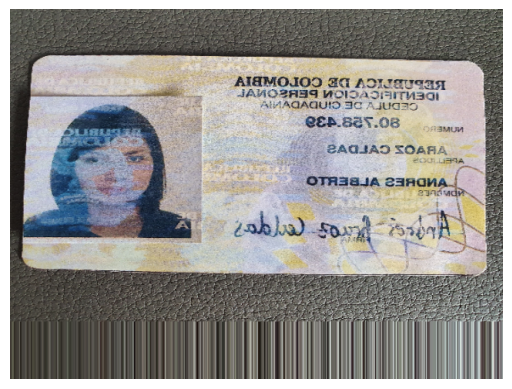

Ejemplo 2


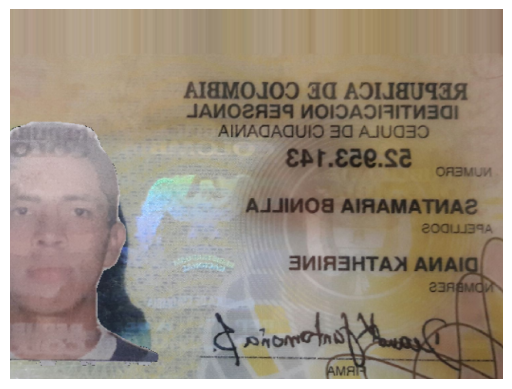


Clase: TRUE
Ejemplo 1


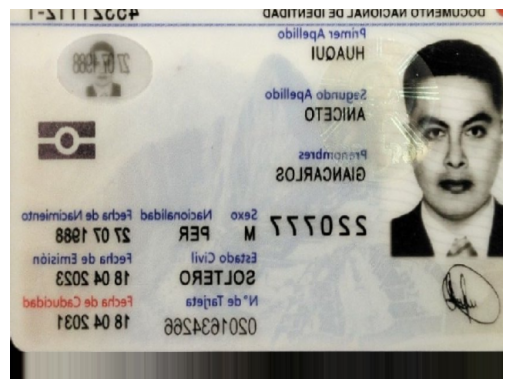

Ejemplo 2


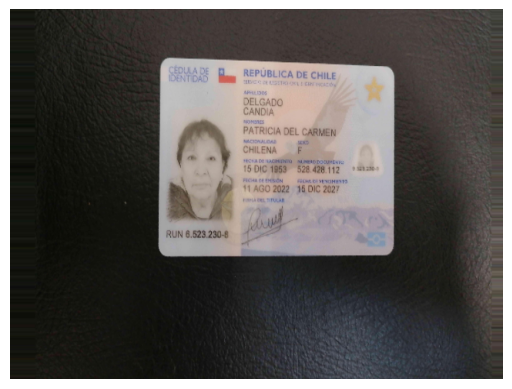

In [10]:
# Crear el generador de datos
train_generator, test_generator, val_generator = create_data_generator(path_data)
visualizar_img_data_generator(val_generator,2)

Found 486 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Clase: FALSE
Ejemplo 1


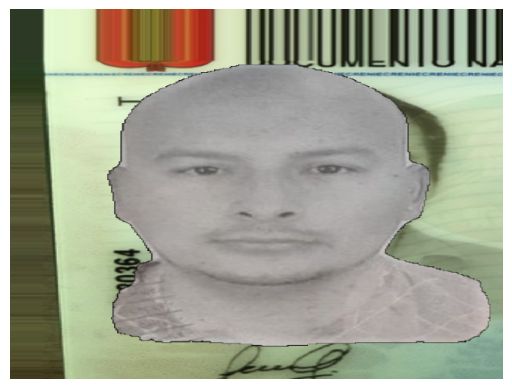

Ejemplo 2


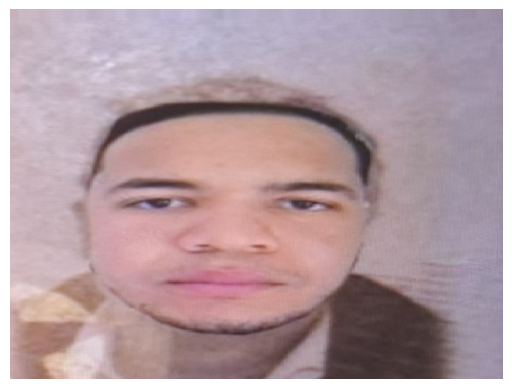


Clase: TRUE
Ejemplo 1


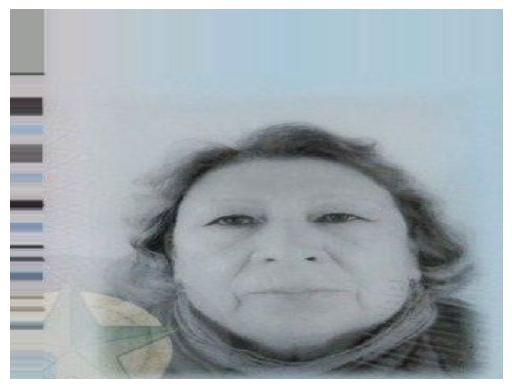

Ejemplo 2


In [ ]:
train_generator, test_generator, val_generator = create_data_generator(os.path.join(path_data, "..","cut"))
visualizar_img_data_generator(train_generator,2)

In [ ]:
print(len(train_generator))
print(len(test_generator))
print(len(val_generator))


10
4
4


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_faster_rcnn_model(width, height, channels,num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, channels)))
    model.add(MaxPooling2D((2, 2)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    # model.add(Dense(num_classes, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))  # Cambio en la activación y num_classes
    return model


# Crear generadores de datos
# train_generator, test_generator, val_generator = create_data_generator(os.path.join(path_data, "..","cut"))
train_generator, test_generator, val_generator = create_data_generator(os.path.join(path_data, "..","cut"))
# visualizar_img_data_generator(train_generator,2)
# Crear modelo Faster R-CNN
model = create_faster_rcnn_model(640, 480, 3,2)

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/../cut/TRUE
/content/drive/MyDrive/DIPLOMADO/DATA-SUPER/DATA_ORG/../cut/FALSE
Found 291 validated image filenames belonging to 2 classes.
Found 97 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.


In [21]:
# # Entrenar el modelo
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluar el modelo
print(test_generator)
loss, accuracy = model.evaluate(test_generator)

Epoch 1/10
10/10 [==============================] - 165s 16s/step - loss: 4.4289 - accuracy: 0.5704 - val_loss: 0.9414 - val_accuracy: 0.4694
Epoch 2/10
10/10 [==============================] - 31s 3s/step - loss: 0.7254 - accuracy: 0.5155 - val_loss: 0.6665 - val_accuracy: 0.5306
Epoch 3/10
10/10 [==============================] - 30s 3s/step - loss: 0.6758 - accuracy: 0.5773 - val_loss: 0.6744 - val_accuracy: 0.6224
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 0.6529 - accuracy: 0.5326 - val_loss: 0.6143 - val_accuracy: 0.6633
Epoch 5/10
10/10 [==============================] - 29s 3s/step - loss: 0.7853 - accuracy: 0.6701 - val_loss: 0.7563 - val_accuracy: 0.5306
Epoch 6/10
10/10 [==============================] - 29s 3s/step - loss: 0.6473 - accuracy: 0.6289 - val_loss: 0.6383 - val_accuracy: 0.7551
Epoch 7/10
10/10 [==============================] - 29s 3s/step - loss: 0.6250 - accuracy: 0.7148 - val_loss: 0.5476 - val_accuracy: 0.8265
Epoch 8/10
10/10 [

In [56]:
from tensorflow.keras.optimizers import Adam
# Crear callbacks
model_loss = 'val_loss'  # Métrica a monitorear para guardar el mejor modelo
checkpoint_path = os.path.join("best_model_lr.h5")
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor=model_loss, save_best_only=True)
early_stop_callback = EarlyStopping(monitor=model_loss, patience=5)

# Compilar el modelo con una tasa de aprendizaje específica
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# # # Entrenar el modelo
# history = model.fit(train_generator, epochs=100, validation_data=val_generator)

# # Entrenar el modelo y guardar el historial
# history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[checkpoint_callback, early_stop_callback])


model_loss = 'val_loss'  # Métrica a monitorear para guardar el mejor modelo

early_stop_callback = EarlyStopping(monitor=model_loss, patience=5)


# Definimos el callback
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="best_model_cnn.h5",
                                                   monitor="val_loss",
                                                   verbose=True,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="min")
# Entrenamos el modelo
hist_tl = model.fit(train_generator,
                       epochs=100,
                       validation_data=val_generator,
                       callbacks=[best_callback, early_stop_callback])


# Evaluar el modelo
print(test_generator)
loss, accuracy = model.evaluate(test_generator)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8900
Epoch 1: val_loss improved from inf to 0.46004, saving model to best_model_cnn.h5
10/10 [==============================] - 32s 3s/step - loss: 0.2904 - accuracy: 0.8900 - val_loss: 0.4600 - val_accuracy: 0.8980
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9072
Epoch 2: val_loss improved from 0.46004 to 0.44082, saving model to best_model_cnn.h5
10/10 [==============================] - 38s 4s/step - loss: 0.2451 - accuracy: 0.9072 - val_loss: 0.4408 - val_accuracy: 0.8673
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.9003
Epoch 3: val_loss did not improve from 0.44082
10/10 [==============================] - 30s 3s/step - loss: 0.2597 - accuracy: 0.9003 - val_loss: 0.5517 - val_accuracy: 0.8878
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8797
Epoch 4: val_loss 

In [57]:
# Evaluar el modelo
print(test_generator)
loss, accuracy = model.evaluate(test_generator)

4/4 [==============================] - 9s 2s/step - loss: 0.4750 - accuracy: 0.8969


In [60]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Directorio para guardar los modelos
model_dir = "modelos"

# Crear la carpeta si no existe
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


# Guardar el modelo en un directorio específico
model_loss = history.history['val_loss'][-1]
model_accuracy = history.history['val_accuracy'][-1]
model_folder = os.path.join(model_dir, f"modelo_{model_loss}_{model_accuracy}")
# os.makedirs(model_folder)
model.save(os.path.join(model_folder, "modelo.h5"))

# Cargar el modelo guardado
loaded_model = load_model(os.path.join(model_folder, "modelo.h5"))

# Matriz de confusión en el conjunto de validación
val_predictions = loaded_model.predict(test_generator)
val_predictions = np.round(val_predictions).flatten()
val_labels = test_generator.labels
confusion_mat = confusion_matrix(val_labels, val_predictions)
print("Matriz de Confusión:")
print(confusion_mat)




4/4 [==============================] - 8s 2s/step
Matriz de Confusión:
[[14 28]
 [18 37]]


In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 638, 478, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 319, 239, 32)     0         
 2D)                                                             
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 159, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 157, 117, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 78, 58, 64)       0         
 2D)                                                             
                                                      

In [29]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.optimizers import Adam

# Compilar el modelo con una tasa de aprendizaje específica
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# # Entrenar el modelo
# history = model.fit(train_generator, epochs=100, validation_data=val_generator)

# Evaluar el modelo
print(test_generator)


# Directorio para guardar los modelos
model_dir = "modelos"

# Crear la carpeta si no existe
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Crear callbacks
model_loss = 'val_loss'  # Métrica a monitorear para guardar el mejor modelo
checkpoint_path = os.path.join(model_dir, "best_model_lr0.001.h5")
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor=model_loss, save_best_only=True)
early_stop_callback = EarlyStopping(monitor=model_loss, patience=5)

# Entrenar el modelo y guardar el historial
history = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_callback, early_stop_callback])

# Cargar el mejor modelo guardado
loaded_model = load_model(checkpoint_path)

# Matriz de confusión en el conjunto de validación
val_predictions = loaded_model.predict(val_generator)
val_predictions = np.round(val_predictions).flatten()
val_labels = val_generator.labels
confusion_mat = confusion_matrix(val_labels, val_predictions)
print("Matriz de Confusión:")
print(confusion_mat)

# # Ejemplo de carga de una imagen y generación de una predicción
# image_path = "ruta/a/la/imagen.png"
# image = tf.keras.preprocessing.image.load_img(image_path, target_size=(480, 640))
# image_array = tf.keras.preprocessing.image.img_to_array(image)
# image_array = image_array / 255.0  # Normalizar los valores de píxeles entre 0 y 1
# image_array = np.expand_dims(image_array, axis=0)

# prediction = loaded_model.predict(image_array)
# if prediction[0] >= 0.5:
#     result = "TRUE"
# else:
#     result = "FALSE"

# print("Predicción:", result)


Epoch 1/200
10/10 [==============================] - 42s 4s/step - loss: 0.2338 - accuracy: 0.9141 - val_loss: 0.3924 - val_accuracy: 0.8980
Epoch 2/200
10/10 [==============================] - 33s 3s/step - loss: 0.2310 - accuracy: 0.9210 - val_loss: 0.4885 - val_accuracy: 0.8878
Epoch 3/200
10/10 [==============================] - 33s 3s/step - loss: 0.2716 - accuracy: 0.8797 - val_loss: 0.7107 - val_accuracy: 0.6735
Epoch 4/200
10/10 [==============================] - 29s 3s/step - loss: 0.2476 - accuracy: 0.9107 - val_loss: 0.4311 - val_accuracy: 0.8878
Epoch 5/200
10/10 [==============================] - 30s 3s/step - loss: 0.2858 - accuracy: 0.8729 - val_loss: 0.4028 - val_accuracy: 0.8673
Epoch 6/200
10/10 [==============================] - 51s 6s/step - loss: 0.2964 - accuracy: 0.9175 - val_loss: 0.2966 - val_accuracy: 0.8878
Epoch 7/200
10/10 [==============================] - 31s 3s/step - loss: 0.2171 - accuracy: 0.9038 - val_loss: 0.5112 - val_accuracy: 0.8776
Epoch 8/200
1

In [30]:
import matplotlib.pyplot as plt
def graph_history(history):
  # Obtener las métricas de precisión y pérdida del historial
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Graficar la precisión
  plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
  plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Graficar la pérdida
  plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
  plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


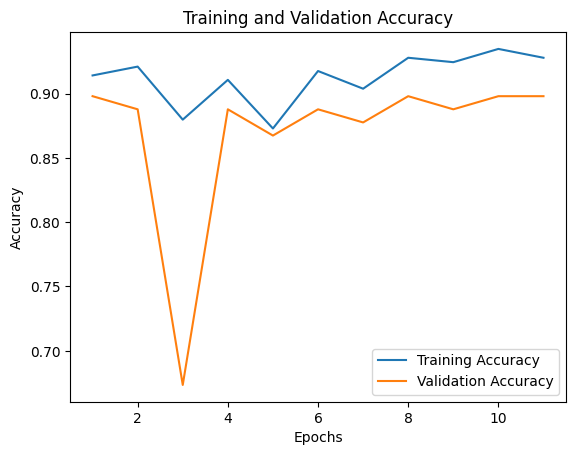

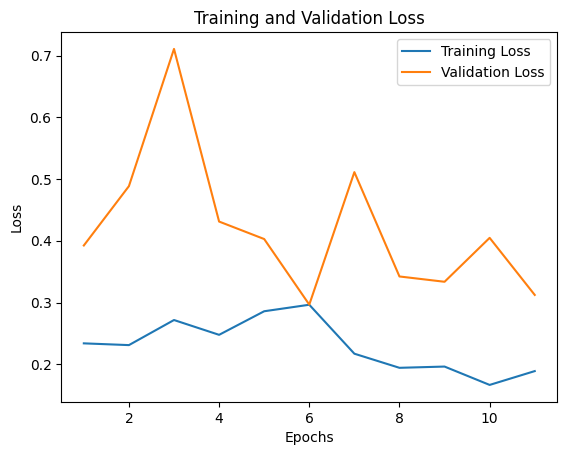

In [87]:
graph_history(history)